In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('normalized_data.csv')
data.head()


,sequence,classification
0,UCAGACUUUU,RNA
1,KGGWFGKHRG,Hybrid
2,KGGWFGKHRG,Hybrid
3,UCCGUGAUAG,Hybrid
4,IVEGSDAEIG,Protein


In [13]:
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

ex = data.classification.value_counts()

a = 'Macro Mol Type'
colors = ['SlateGray','Orange','Green','DodgerBlue']
fig = {
      "data": [
        {
          "values":ex.values,
          "labels":ex.index,
          "text":a,
          "textposition":"inside",
          "textfont": {'size':12,'color':'white'},  
          "name": a,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          'marker':{'colors':colors
                   },
          "type": "pie"
        }],
    "layout": {
            "title":"Macro Molecule type Distribution",
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": a,
                    "x": 0.50,
                    "y": 0.5
                }]
            }
        }
iplot(fig)                            

In [2]:
data = data.dropna()
#print(data.shape)
print(data.isnull().sum())
#data = data.values

sequence          0
classification    0
dtype: int64


In [3]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# maximum length of sequence, everything afterwards is discarded!
max_length = 512
seqs = data.sequence.values
#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

Using TensorFlow backend.
/Users/faisalg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/faisalg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/faisalg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/faisalg/anaconda3/lib/python3.6/site-packag

In [4]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(data.classification)

In [5]:
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
embedding_dim = 8

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 8)            184       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512, 400)          334400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               961600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 1,336,688
Trainable params: 1,336,688
Non-trainable params: 0
_________________________________________________________________
None
Train on 1336 samples, validate on 334 samples
Epoch 1/10
1336/1336 [==============================] - 209s 156ms/step - loss: 

In [12]:
%matplotlib inline
import matplotlib as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))*100))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))*100))





train-acc = 81.3622754491018
test-acc = 77.54491017964071


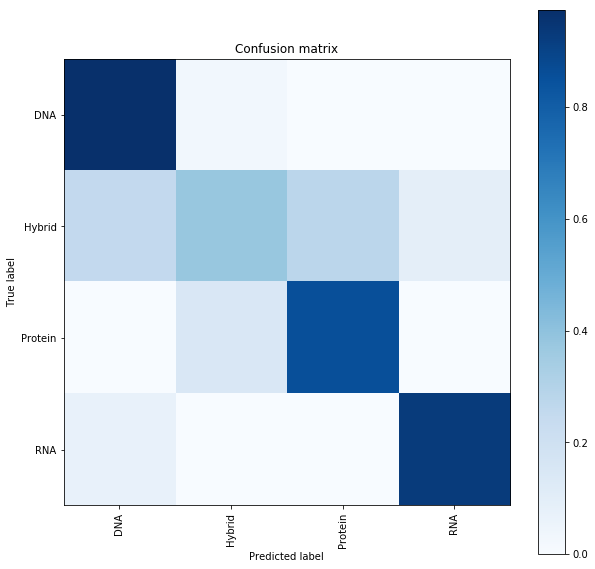

              precision    recall  f1-score   support

         DNA       0.72      0.97      0.83        74
      Hybrid       0.69      0.38      0.49        87
     Protein       0.76      0.86      0.81        90
         RNA       0.91      0.93      0.92        83

   micro avg       0.78      0.78      0.78       334
   macro avg       0.77      0.78      0.76       334
weighted avg       0.77      0.78      0.76       334



In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

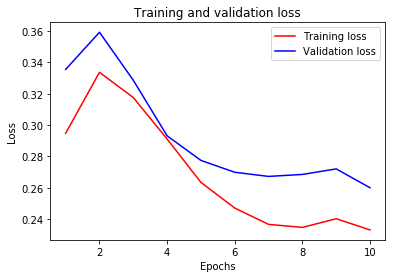

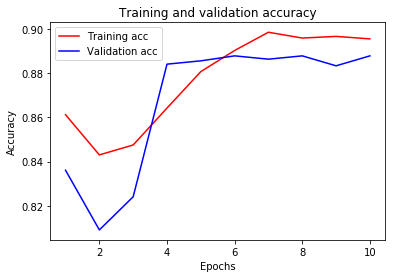

In [14]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=128)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 512, 8)            184       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 32)           800       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 256, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 256, 32)           3104      
_________________________________________________________________
lstm_9 (LSTM)                (None, 256, 100)          53200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 404       
Total para

train-acc = 88.47305389221557
test-acc = 79.64071856287424


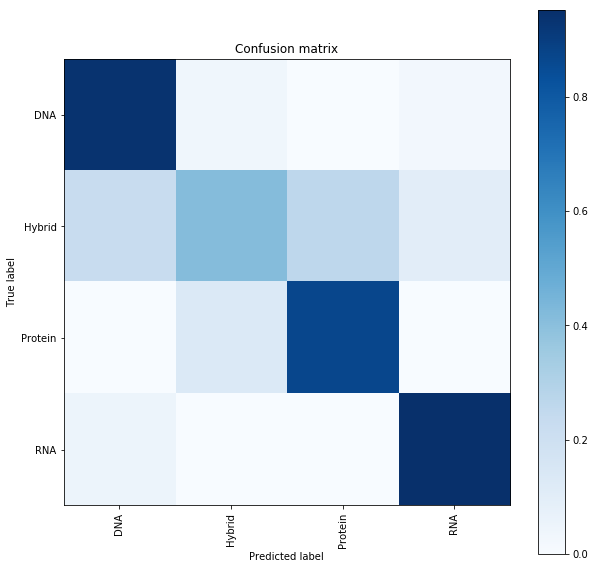

              precision    recall  f1-score   support

         DNA       0.78      0.94      0.85        82
      Hybrid       0.69      0.41      0.52        80
     Protein       0.79      0.87      0.83        91
         RNA       0.89      0.95      0.92        81

   micro avg       0.80      0.80      0.80       334
   macro avg       0.79      0.79      0.78       334
weighted avg       0.79      0.80      0.78       334



In [20]:
%matplotlib inline
import matplotlib as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))*100))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))*100))

import matplotlib.pyplot as plt
%matplotlib inline
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

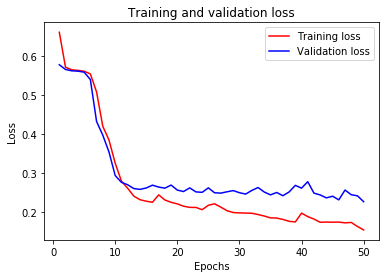

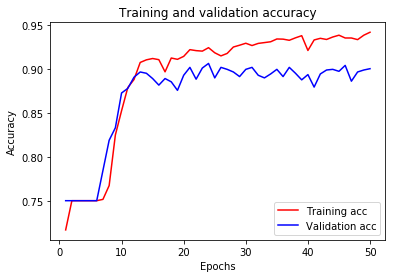

In [21]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,GRU
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(200,return_sequences=True))
model.add(GRU(200))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 512, 8)            184       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 512, 32)           800       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 256, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128, 200)          139800    
_________________________________________________________________
gru_6 (GRU)                  (None, 200)               240600    
__________

train-acc = 95.73353293413174
test-acc = 90.41916167664671


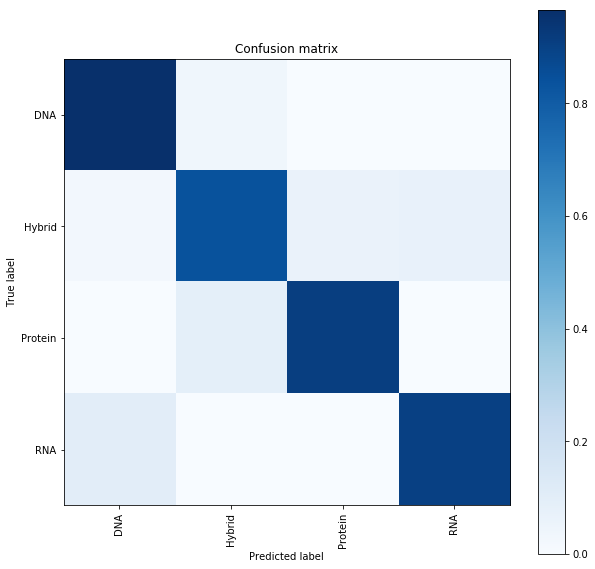

              precision    recall  f1-score   support

         DNA       0.88      0.96      0.92        85
      Hybrid       0.87      0.84      0.85        80
     Protein       0.93      0.91      0.92        78
         RNA       0.93      0.90      0.92        91

   micro avg       0.90      0.90      0.90       334
   macro avg       0.90      0.90      0.90       334
weighted avg       0.90      0.90      0.90       334



In [27]:
%matplotlib inline
import matplotlib as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))*100))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))*100))

import matplotlib.pyplot as plt
%matplotlib inline
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

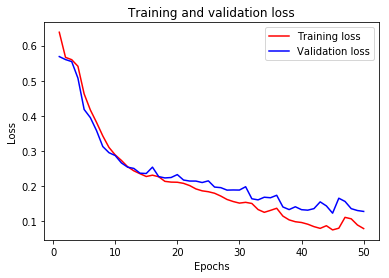

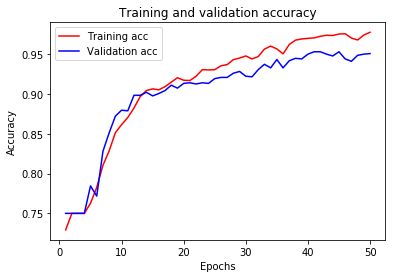

In [28]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,GRU
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(GRU(200,return_sequences=True))
model.add(GRU(200,return_sequences=True))
model.add(GRU(200))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=128)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 512, 8)            184       
_________________________________________________________________
gru_9 (GRU)                  (None, 512, 200)          125400    
_________________________________________________________________
gru_10 (GRU)                 (None, 512, 200)          240600    
_________________________________________________________________
gru_11 (GRU)                 (None, 200)               240600    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 804       
Total params: 607,588
Trainable params: 607,588
Non-trainable params: 0
_________________________________________________________________
None
Train on 1336 samples, validate on 334 samples
Epoch 1/50
1336/1336 [==============================] - 64s 48ms/step - loss: 0.6317